In [1]:
import skimage as sk
from skimage import io, util, img_as_uint
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import cv2
import torch
import torch.nn as nn
import math, sys, os
from ResDNet import *
from MMNet import *
from problems import *
import glob
from scipy import signal
import pickle
from subprocess import call, check_output
import utilities

# Define HyperParameters

In [2]:
args_noise_estimation = True # wheter to estimate noise or not
args_init = True # wheter to initialize the input with bilinear
args_use_gpu = True 
args_block_size = (512,512)
batch_size = 4
args_model = 'pretrained_models/demosaicking/noisy/' # model path
# Define folder with RAW images
args_img_folder = 'misc/4KK2_20150912_130944_798/4KK2_20150912_130944_798/' # folder of RAW images
args_output_folder = 'output/' # save results to folder
args_type = '.png' # image type to save as
   
reference = 3 # Index of reference frame using 0-based numbering
tmp_path = 'tmp/'
files = glob.glob(tmp_path+'*.pkl')
for f in files:
    os.remove(f)

# Load Model

In [3]:
model_params = torch.load(args_model+'model_best.pth')

model = ResDNet(BasicBlock, model_params[2], weightnorm=True)
mmnet = MMNet(model, max_iter=model_params[1])
for param in mmnet.parameters():
    param.requires_grad = False

mmnet.load_state_dict(model_params[0])
if args_use_gpu:
    mmnet = mmnet.cuda()
    print('use gpu')

use gpu


In [5]:
if not os.path.exists(args_output_folder):
    os.makedirs(args_output_folder)
    
filepaths_img = glob.glob(args_img_folder+'*.dng')
filepaths_img.sort()
imgs = []

for img_path in filepaths_img:
    call(["dcraw","-d","-T","-6","-w", img_path])  # convert to TIFF with minimal processing

    img_path_new = img_path.split(".")
    img_path_new[-1] = '.tiff'
    img_path_new = "".join(img_path_new)
    img = io.imread(img_path_new)
    
    # Convert to RGGB
    rollx, rolly = utilities.check_pattern(img_path)  
    img = img[rollx:-rollx,rolly:-rolly] 
    
    res = utilities.rescale_to_255f(img) # model uses as input [0,255] representation
    imgs.append({'name':img_path,'img':res})
imgs.append(imgs[reference])
del imgs[reference]

# convert all frames from raw [B, H, W] to Bayer [B, H, W, 3]
burst = np.array([utilities.raw_to_bayer(img['img']) for img in imgs])

warp_matrices = utilities.calculate_affine_matrices(burst)
burst = burst.sum(axis=-1)

# pad according to block size
if burst.shape[1] % args_block_size[1] != 0:
    mod = args_block_size[0]- burst.shape[1] % args_block_size[0]
    burst = np.array([np.pad(b, ((0,mod),(0,0)), 'reflect') for b in burst])

if burst.shape[2] % args_block_size[1] != 0:
    mod = args_block_size[1]- burst.shape[2] % args_block_size[1]
    burst = np.array([np.pad(b, ((0,0), (0,mod)), 'reflect') for b in burst])

blocks = util.view_as_blocks(burst, block_shape=(burst.shape[0],*args_block_size))

def process_patch(patch):
    r""" Process a patch with shape [b, B, H, W].
         Every necessary component is created.
    """
    with torch.no_grad():
        mmnet.eval()
        
        # input image
        mosaic = np.array([utilities.raw_to_bayer(p) for p in patch])
        mosaic = torch.FloatTensor(mosaic).permute(0,3,1,2)
        mosaic = mosaic.float()[None]
        shape = mosaic[0].shape
        
        # initiliaze mosaick operator
        mask = torch.zeros_like(mosaic)
        mask[:,:,0,::2,::2] = 1
        mask[:,:,1,::2,1::2] = 1
        mask[:,:,1,1::2,::2] = 1
        mask[:,:,2,1::2,1::2] = 1
        
        warp_matrices_T = torch.FloatTensor(warp_matrices)[None]
        p = Burst_Demosaick_Denoise(mosaic.float(), mask.float(), warp_matrices_T)
        if args_use_gpu:
            p.cuda_()

        xcur = mmnet.forward_all_iter(p, max_iter=mmnet.max_iter, init=args_init, noise_estimation=True)
        return xcur[0].cpu().data.permute(1,2,0).numpy()

# demosaick image
block_size = blocks.shape[-2:]
num_blocks = blocks.shape[:3]
original_size = (blocks.shape[1] * blocks.shape[4], blocks.shape[2] * blocks.shape[5])
final_img = np.zeros((original_size[0], original_size[1],3), dtype=np.float64)

# process each patch and then place the result at appropriate location
for i in range(num_blocks[1]):
    for j in range(num_blocks[2]):
        patch_result = process_patch(blocks[0,i,j])
        final_img[i*block_size[0]:(i+1)*block_size[0], j*block_size[1]:(j+1)*block_size[1]] = patch_result

final_img = final_img[:img.shape[0],:img.shape[1]]
io.imsave('final_img.jpg',img_as_uint(final_img/255))

/home/filippos/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/filippos/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


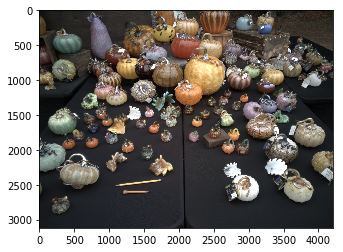

In [6]:
plt.imshow(final_img/255)